<a href="https://colab.research.google.com/github/GulnazaS/Fake-or-real-news/blob/main/%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%84%D0%B0%D0%BB%D1%8C%D1%88%D0%B8%D0%B2%D1%8B%D1%85_%D0%BD%D0%BE%D0%B2%D0%BE%D1%81%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек и загрузка датасета

In [101]:
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as sk_metrics
from sklearn. metrics import mean_absolute_error as mae

In [9]:
categories = ["fake", "real"]
labels = [0, 1]
df = pd.read_csv('/content/fake_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Исследование датасета

In [10]:
#Размерность массива
df.shape

(6335, 4)

In [11]:
#Заголовки массива
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [12]:
#Общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [13]:
# Поиск нулевых значений
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

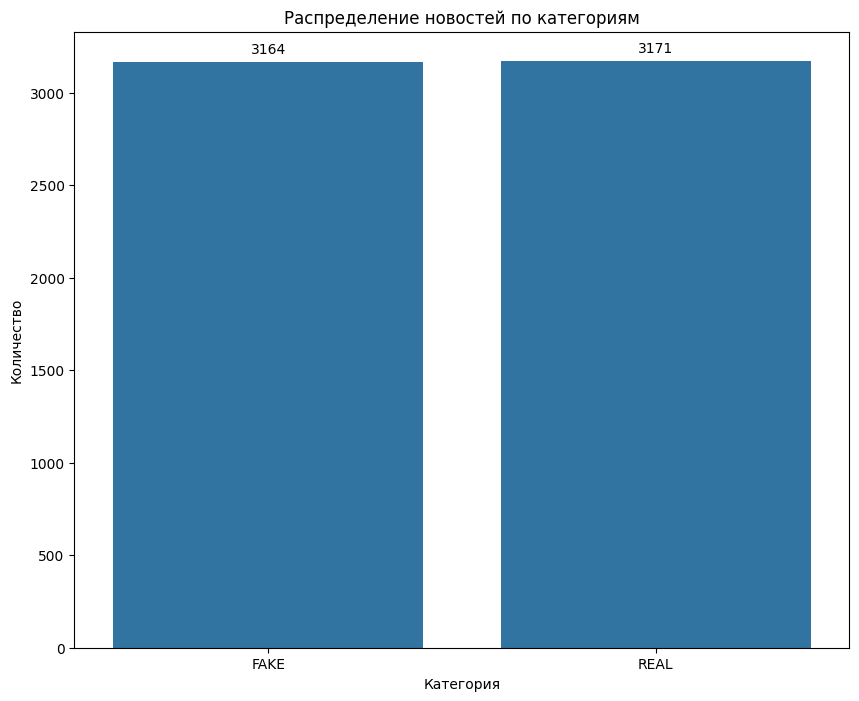

In [16]:
plt.figure(figsize=(10,8))
sns.countplot(x=df['label'])
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.title("Распределение новостей по категориям")

#Добавление значений к каждому столбцу
ax = plt.gca()  # Получение текущей оси графика
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.0f'),
  (p.get_x() + p.get_width() / 2., p.get_height()),
  ha='center', va='center',
  xytext=(0, 9),
  textcoords='offset points')

plt.show()

In [17]:
labels=df.label
labels.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

## Обучение модели

In [27]:
#Приведение значений к int
df['label'] = np.where(df['label']=='REAL', 1, 0)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [31]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [32]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [64]:
pac = PassiveAggressiveClassifier()
epochs = 10
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
for epoch in range(0, epochs):
  pac.fit(tfidf_train, y_train)
  y_pred = pac.predict(tfidf_test)
  train_loss = mean_squared_error(y_train, pac.predict(tfidf_train))
  val_loss = mean_squared_error(y_test, y_pred)
  train_acc = accuracy_score(y_train, pac.predict(tfidf_train))
  val_acc = accuracy_score(y_test, y_pred)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracy.append(train_acc)
  val_accuracy.append(val_acc)
  print(f'Эпока {epoch}:')
  print(f'Обучающая ошибка: {train_loss*100}%, Обучающая точность: {train_acc* 100}%')
  print(f'Валидационная ошибка: {val_loss*100}%, Валидационная точность: {val_acc*100}%')

Эпока 0:
Обучающая ошибка: 0.0%, Обучающая точность: 100.0%
Валидационная ошибка: 6.235201262825572%, Валидационная точность: 93.76479873717443%
Эпока 1:
Обучающая ошибка: 0.0%, Обучающая точность: 100.0%
Валидационная ошибка: 6.550907655880031%, Валидационная точность: 93.44909234411996%
Эпока 2:
Обучающая ошибка: 0.0%, Обучающая точность: 100.0%
Валидационная ошибка: 5.919494869771113%, Валидационная точность: 94.08050513022889%
Эпока 3:
Обучающая ошибка: 0.0%, Обучающая точность: 100.0%
Валидационная ошибка: 6.235201262825572%, Валидационная точность: 93.76479873717443%
Эпока 4:
Обучающая ошибка: 0.0%, Обучающая точность: 100.0%
Валидационная ошибка: 6.787687450670877%, Валидационная точность: 93.21231254932913%
Эпока 5:
Обучающая ошибка: 0.0%, Обучающая точность: 100.0%
Валидационная ошибка: 6.471981057616416%, Валидационная точность: 93.52801894238358%
Эпока 6:
Обучающая ошибка: 0.0%, Обучающая точность: 100.0%
Валидационная ошибка: 6.393054459352802%, Валидационная точность: 93.6

In [65]:
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.53%


## Оценка производительности

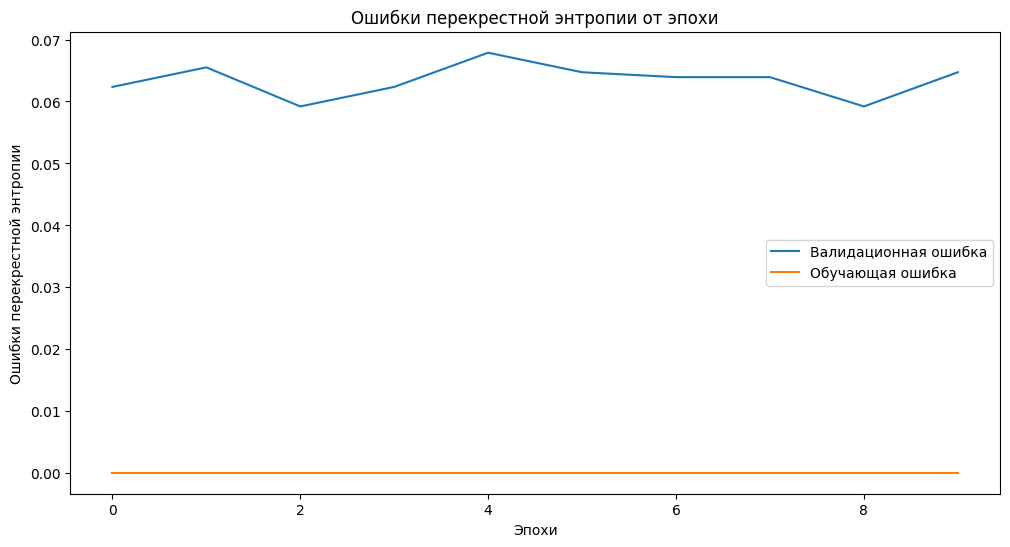

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, epochs), val_losses, label='Валидационная ошибка')
plt.plot(range(0, epochs), train_losses, label='Обучающая ошибка')
plt.title('Ошибки перекрестной энтропии от эпохи')
plt.xlabel('Эпохи')
plt.ylabel('Ошибки перекрестной энтропии')
plt.legend()
plt.show()

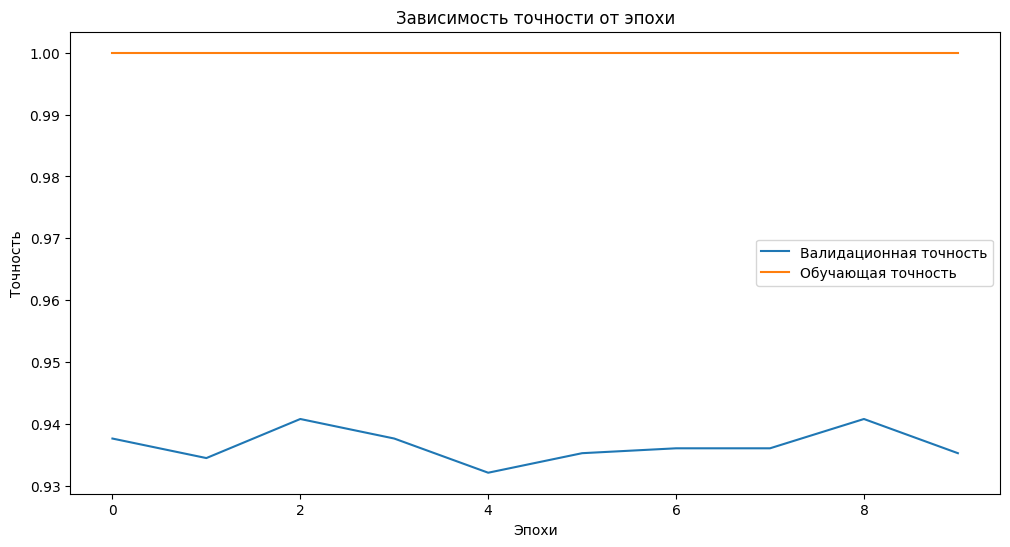

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, epochs), val_accuracy, label='Валидационная точность')
plt.plot(range(0, epochs), train_accuracy, label='Обучающая точность')
plt.title('Зависимость точности от эпохи')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [85]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[588  40]
 [ 42 597]]


Text(0.5, 23.52222222222222, 'Предсказанный вид новостей')

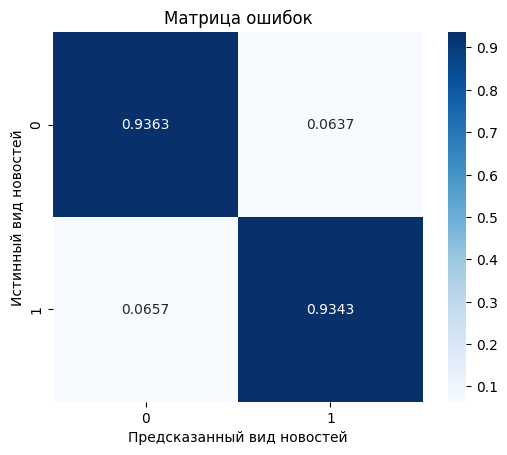

In [93]:
confusion_matrix(y_test, y_pred,labels=[0,1])
confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
axis_labels = range(2)
ax = sns.heatmap(
                confusion_normalized,
                xticklabels=axis_labels,
                yticklabels=axis_labels,
                cmap='Blues',
                annot=True,
                fmt='.4f',
                square=True
                )
plt.title("Матрица ошибок")
plt.ylabel("Истинный вид новостей")
plt.xlabel("Предсказанный вид новостей")

In [94]:
#Среднеквадратическая ошибка (MSE)
def mse(y_test, y_pred):
 actual, pred = np.array(y_test), np.array(y_pred)
 return np.square(np.subtract(y_test,y_pred)).mean()

In [95]:
mse(y_test, y_pred)

0.06471981057616416

In [96]:
#Корень среднеквадратической ошибки (RMSE)
def rmse(y_test, y_pred):
 actual, pred = np.array(y_test), np.array(y_pred)
 return np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())

In [97]:
rmse(y_test, y_pred)

0.25440088556481905

In [99]:
#Средняя абсолютная ошибка
mae(y_test, y_pred)

0.06471981057616416